# Detecting rooftop available surface for installing PV modules in aerial images using Machine Learning

In [1]:
import numpy as np
import matplotlib.pyplot  as plt
import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset

from process_data.data_noara_loader import *
from model.unet import *
from loss.loss import *
from process_data.data_loader import *
from process_data.data_noara_loader import *
from hyperparameters.select_param import *
from process_data.import_test import *

%load_ext autoreload
%autoreload 2

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the Data Set
First we load the data set that we will use for training. Each sample is an image with its mask (label). An image is represented as a 3x250x250 array with each of the 3 color chanel being 250x250 pixels. The asssociated mask is a 250x250 array, 

In [21]:
folder_path_image = 'data/image'
folder_path_mask  = 'data/mask'
folder_path_noara  = 'data/noARA'

#load dataset
train_dataset = DataLoaderSegmentation(folder_path_image,folder_path_mask)
noara_dataset = DataLoaderNoARA(folder_path_noara)
print(len(train_dataset),print(noara_dataset))
#combine two datasets
train_loader = DataLoader(ConcatDataset([train_dataset,noara_dataset]),batch_size=5, shuffle=True ,num_workers=0)
print(len(train_loader))

450 None
132


# Initiate the model
In this report, we will use the Unet model presented in medical image segmentation, and in the previous papers of the Professor.

In [3]:
model = UNet(3,1,False).to(device)
print(model)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Loss & Optimizer

In [3]:
loss_function = torch.nn.BCEWithLogitsLoss(weight=torch.FloatTensor([6]).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

NameError: name 'torch' is not defined

# Training Loop

In [6]:
num_epochs = 200
model = UNet(3,1,False).to(device)

trained_model = training_model(train_loader,loss_function,optimizer,model,num_epochs)

Epoch n. 0 Loss 4.0969 Time Remaining 47.7672
Epoch n. 1 Loss 4.0967 Time Remaining 46.2813
Epoch n. 2 Loss 4.0999 Time Remaining 45.7841
Epoch n. 3 Loss 4.1006 Time Remaining 45.0683
Epoch n. 4 Loss 4.0996 Time Remaining 44.4474
Epoch n. 5 Loss 4.097 Time Remaining 43.8672
Epoch n. 6 Loss 4.0988 Time Remaining 43.171
Epoch n. 7 Loss 4.0979 Time Remaining 42.5732
Epoch n. 8 Loss 4.0967 Time Remaining 41.8716
Epoch n. 9 Loss 4.0957 Time Remaining 41.2705
Epoch n. 10 Loss 4.0981 Time Remaining 40.5089
Epoch n. 11 Loss 4.0967 Time Remaining 39.8129
Epoch n. 12 Loss 4.0975 Time Remaining 39.2002
Epoch n. 13 Loss 4.0965 Time Remaining 38.5034
Epoch n. 14 Loss 4.0952 Time Remaining 37.8671
Epoch n. 15 Loss 4.0969 Time Remaining 37.1882
Epoch n. 16 Loss 4.0976 Time Remaining 36.5147
Epoch n. 17 Loss 4.0981 Time Remaining 35.8005
Epoch n. 18 Loss 4.0979 Time Remaining 35.1389
Epoch n. 19 Loss 4.0935 Time Remaining 34.4793
Epoch n. 20 Loss 4.0957 Time Remaining 33.7816
Epoch n. 21 Loss 4.0957 T

In [13]:
model = trained_model

NameError: name 'trained_model' is not defined

## Export trained model

In [14]:
torch.save(model.state_dict(), 'model/trained_model.pt')

PermissionError: [Errno 13] Permission denied: 'model/trained_model.pt'

In [5]:
path = 'model/'+input('Name of the model file:')
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Cross Validation

In [48]:
loss_function = torch.nn.BCEWithLogitsLoss()
input_model = UNet(3,1,False).to(device)
num_epochs = 2
lr = 0.01

iou_, acc_ = cross_validation(train_dataset, loss_function, input_model, num_epochs, lr)

Epoch n. 0 Loss 0.83
Epoch n. 1 Loss 0.7447
Iter 0: IoU = 0.0 /  Accuracy = 0.8391
Epoch n. 0 Loss 0.6307
Epoch n. 1 Loss 0.7163
Iter 1: IoU = 0.0 /  Accuracy = 0.8373

Average test IoU: 0.000000
Variance test IoU: 0.000000

Average test accuracy: 0.838194
Variance test accuracy: 0.000001


# Tuning the hyper parameters
We may do a grid search on the learning rates with cross validation to find the best learning_rate. For now the used metric is iou.

In [921]:
lr_candidates = np.logspace(-1,-2,3)
num_epochs = 70
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([6]).cuda())

input_model = UNet(3,1,False).to(device)

best_lr, best_model, best_iou = select_hyper_param(train_dataset,loss_function,input_model,num_epochs,lr_candidates)


---------------------------------------------------------------------

Learning Rate = 0.01

Epoch n. 0 Loss 1.143 Time Remaining 3.3366
Iter 0: IoU = 0.2007 /  Accuracy = 0.7205
Epoch n. 0 Loss 1.0676 Time Remaining 3.5265
Iter 1: IoU = 0.2048 /  Accuracy = 0.7414

Average test IoU: 0.202776
Variance test IoU: 0.000004

Average test accuracy: 0.730955
Variance test accuracy: 0.000109
---------------------------------------------------------------------

Learning Rate = 0.0001

Epoch n. 0 Loss 1.0044 Time Remaining 3.3899
Iter 0: IoU = 0.2289 /  Accuracy = 0.7554
Epoch n. 0 Loss 1.0052 Time Remaining 3.2632
Iter 1: IoU = 0.2123 /  Accuracy = 0.7547

Average test IoU: 0.220570
Variance test IoU: 0.000069

Average test accuracy: 0.755032
Variance test accuracy: 0.000000


In [878]:
torch.save(best_model.state_dict(), 'model/best_model.pt')

In [68]:
model = best_model

NameError: name 'best_model' is not defined

In [863]:
best_lr, best_iou

(0.0001, 0.3775347806849417)

# Visualization of the model

## Display a image with its mask

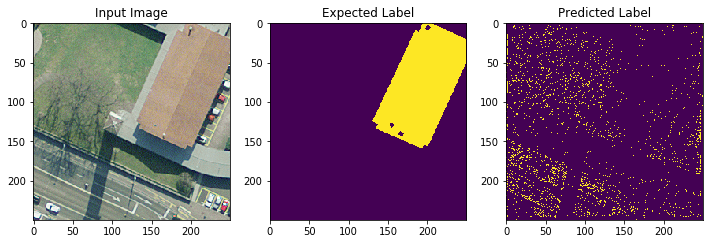

0.0109 0.776112


In [19]:
fig = plt.figure()
fig.set_size_inches(12, 7, forward=True)

ax1 = fig.add_subplot(1,3,1)
ax1.title.set_text('Input Image')
ax2 = fig.add_subplot(1,3,2)
ax2.title.set_text('Expected Label')
ax3 = fig.add_subplot(1,3,3)
ax3.title.set_text('Predicted Label')

acc = 0

index_random_sample = int(np.random.random()*len(train_loader.dataset))
(x,y) = train_loader.dataset[index_random_sample]
ax1.imshow(np.transpose(x.numpy(),(1,2,0)))

ax2.imshow(y)

ypred = torch.squeeze(model(torch.unsqueeze(x,0).cuda())).cpu().detach().numpy()
ax3.imshow(np.around(ypred))
np.around(iou(np.around(ypred),y.numpy()),4),accuracy(np.around(ypred),y.numpy())
acc = np.around(iou(np.around(ypred),y.numpy()),4)
plt.show()
print(acc,accuracy(np.around(ypred),y.numpy()))

## Display an unseen image

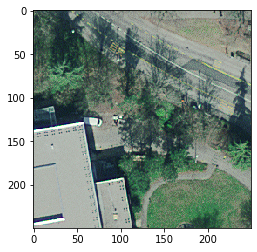

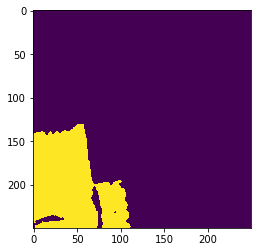

In [934]:
import_and_show(model,'test.png') # Note that 'test.png' should be located in the root of the folder